# Load .mat file

In [1]:
import sandbox as sb
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os

In [2]:
filePath = '/Users/ivanaescobar/Dropbox/UT_CSEM_2016-202*/research/crios_research/ARL_nesba/YT_data_fig_Sharp_ssp/'
if (os.uname()[0] == 'Linux'):
    filePath = '/scratch2/ivana/regionalgcm/data/'
fileName = 'Sharp_xshelf_ctd59-69.mat'
file = filePath + fileName

In [3]:
mat = sb.loadMatFile(file)
keys_to_remove = ("__header__", "__version__", "__globals__")
for k in keys_to_remove:
    mat.pop(k, None)

In [4]:
print(type(mat))
print(mat.keys())

<class 'dict'>
dict_keys(['ibdpth', 'idpth', 'ilat', 'ilon', 'isalt', 'isvcm', 'itemp', 'lat', 'lon', 'salt', 'sname', 'svcm', 'temp'])


In [5]:
mat['lat'].shape

(1, 11)

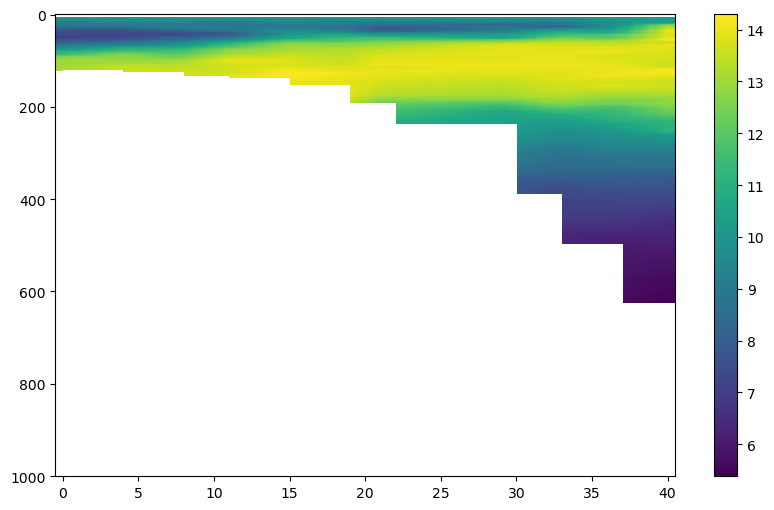

In [6]:
plt.figure(figsize=(10,6))
plt.imshow(mat["itemp"], aspect="auto")
plt.colorbar()

# Convert to xarray DataSet

modify dictionary to use **from_dict** xarray method

only saving:
- *ibdpth*: Dimension of dataSet
- *idpth*: Dimension of dataSet
- *ilat*: unused latitutdes 
- *ilon*: unused longitutdes 
- *isalt*: Data variable salinity
- *isvcm*: Data variable sound speed
- *itemp*: Data variable temperature

Other info: 
* Send source signature from TM4 experiment for time series modeling : \
TM4 source 4 second long chirp, bandwidth 775 Hz – 475 Hz.  Source depth:  81 m \
* Send lat, lon, depth coordinates of TM4 and AT: \
TM4:  39° 50.8542'N 70° 54.0876'W;  \
AT:  39° 57.150'N   70° 53.167'W

In [7]:
import xarray as xr

In [8]:
def makeDataSet (matlabDictionary):
    # IN: MATLab mat file loaded,
    # OUT: ds DataSet
    
    r = [len(matlabDictionary["ibdpth"])-i-1 for i in range(len(matlabDictionary["ibdpth"]))]
    z = [i for i in range(len(matlabDictionary["idpth"]))]
    
    #calc distances
    ranges = [0]
    for rr in range(len(matlabDictionary["ibdpth"])-1):
        distance = sb.wgs84Distance(matlabDictionary["ilon"][0][rr],   matlabDictionary["ilat"][0][rr],
                                    matlabDictionary["ilon"][0][rr+1], matlabDictionary["ilat"][0][rr+1])
        ranges.append( ranges[-1] + distance / 1000. )
    ranges.reverse()
    
    d = {
        "r":     {"dims": ("r"),     "data":r},
        "z":     {"dims": ("z"),     "data":z},
        "range": {"dims": ("r"),     "data":ranges},
        "depth": {"dims": ("r"),     "data":list(matlabDictionary["ibdpth"].flat)},
        "lat":   {"dims": ("r"),     "data":list(matlabDictionary["ilat"].flat)},
        "lon":   {"dims": ("r"),     "data":list(matlabDictionary["ilon"].flat)},
        "salt":  {"dims": ("z","r"), "data":matlabDictionary["isalt"].tolist()},
        "temp":  {"dims": ("z","r"), "data":matlabDictionary["itemp"].tolist()},
        "ss":    {"dims": ("z","r"), "data":matlabDictionary["isvcm"].tolist()}
    }
    ds = xr.Dataset.from_dict(d)
    ds = ds.sortby('r')
    
    # Assign attributes
    ds.range.attrs['long_name'] = 'range'
    ds.range.attrs['unit'] = 'km'
    ds.z.attrs['long_name'] = 'depth'
    ds.z.attrs['unit'] = 'm'
    ds.depth.attrs['long_name'] = 'maximum depth'
    ds.depth.attrs['unit'] = 'm'
    ds.ss.attrs['long_name'] = 'sound speed'
    ds.ss.attrs['unit'] = 'm/s'
    
    return ds

def makeCTDDataSet (matlabDictionary):
    # IN: MATLab mat file loaded,
    # OUT: ds DataSet

    r = [i for i in range(matlabDictionary["lat"].shape[1])]
    z = [i for i in range(len(matlabDictionary["idpth"]))]

    #calc distances
    ranges = [0]
    for rr in range(matlabDictionary["lat"].shape[1]-1):
        distance = sb.wgs84Distance(matlabDictionary["lon"][0][rr],   matlabDictionary["lat"][0][rr],
                                    matlabDictionary["lon"][0][rr+1], matlabDictionary["lat"][0][rr+1])
        ranges.append( ranges[-1] + distance / 1000. )
    ranges.reverse()

    d = {
        "r":     {"dims": ("r"),     "data":r},
        "z":     {"dims": ("z"),     "data":z},
        "range": {"dims": ("r"),     "data":ranges},
        "lat":   {"dims": ("r"),     "data":list(matlabDictionary["lat"].flat)},
        "lon":   {"dims": ("r"),     "data":list(matlabDictionary["lon"].flat)},
        "salt":  {"dims": ("z","r"), "data":matlabDictionary["salt"].tolist()},
        "temp":  {"dims": ("z","r"), "data":matlabDictionary["temp"].tolist()},
        "ss":    {"dims": ("z","r"), "data":matlabDictionary["svcm"].tolist()}
    }
    ds = xr.Dataset.from_dict(d)
    ds = ds.sortby('r')

    # Assign attributes
    ds.range.attrs['long_name'] = 'range'
    ds.range.attrs['unit'] = 'km'
    ds.z.attrs['long_name'] = 'depth'
    ds.z.attrs['unit'] = 'm'
    ds.ss.attrs['long_name'] = 'sound speed'
    ds.ss.attrs['unit'] = 'm/s'
    
    return ds

In [9]:
ds    = makeDataSet(mat)
dsCTD = makeCTDDataSet(mat)

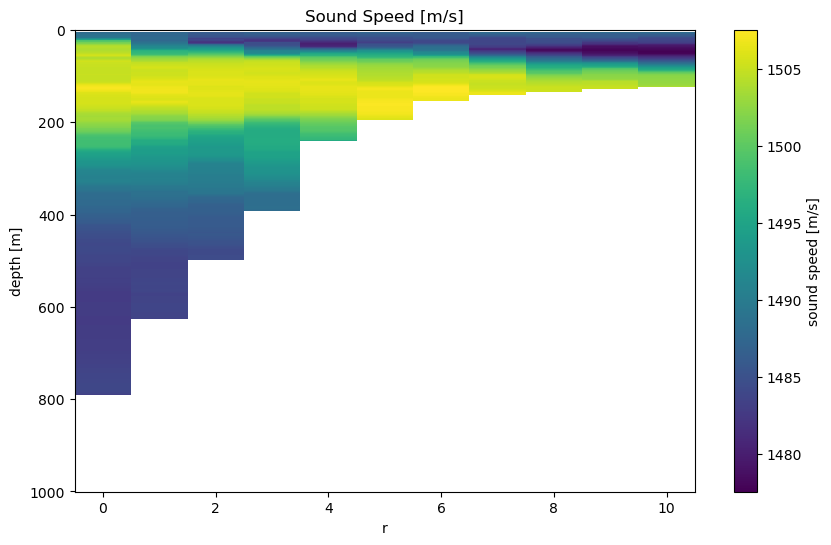

In [10]:
plt.figure(figsize=(10,6))
dsCTD.ss.plot(yincrease=False)
plt.title('Sound Speed [m/s]');

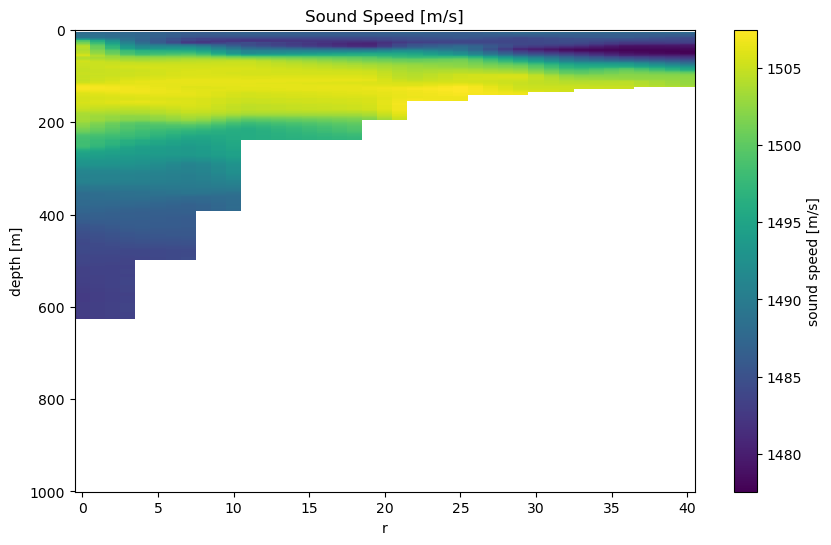

In [11]:
plt.figure(figsize=(10,6))
ds.ss.plot(yincrease=False)
plt.title('Sound Speed [m/s]');

In [12]:
ds.depth.values

array([872.30666667, 814.28514286, 759.29028571, 695.28219048,
       648.04413397, 603.89385965, 564.74898246, 537.74015789,
       515.17027451, 489.65060784, 460.15      , 426.31295238,
       398.63161905, 374.71528571, 347.54587755, 323.72673469,
       299.90759184, 278.01906122, 258.68563265, 239.35975   ,
       222.62384615, 207.36637821, 191.44666667, 179.84057286,
       168.99047906, 158.53661642, 153.33192982, 147.81544498,
       143.69969378, 142.09413716, 140.42064516, 138.74260215,
       137.30348387, 135.94093802, 134.57869347, 133.21644891,
       131.77953769, 130.0844537 , 128.48492901, 127.08913117,
       125.69333333])

# Save data set to netcdf

In [15]:
runName = 'nesba-tm4'
if (os.uname()[0] == 'Linux'):
    runName = 'nesba-tm4_sverdrup'
ds.to_netcdf(filePath+runName+'.nc')
dsCTD.to_netcdf(filePath+runName+'_CTD.nc')

<sub> Written by Ivana Escobar on June 2022